# Autoencoders

> Final project as a Deep Learning for Computer Vision class requirement &#128187;

Jesús E. Hermosilla D.

### Contents

0. Introduction
1. Hyperparameter Search
2. Deep Autoencoders
3. Sparse Autoencoders
4. Denoising Autoencoders
5. Anomaly Detection

## Introduction

Autoencoders (AEs) were first proposed by Rumelhart in 1986. These neural networks are specifically built to learn representations of input data and accurately reconstruct it. AEs work by compressing the input into a concise, meaningful representation and then decoding it to recreate the original data. Classical AEs generally comprises an input layer, a single hidden layers, and an output layer; however, this is not a requirement. In other hand, stacked AEs (or deep AEs), contains multiple hidden layers.

<center>
<img width="278" height="292" src="images/structure.png"/>
</center> 

### References

- Berahmand, K., Daneshfar, F., Salehi, E. S., Li, Y., & Xu, Y. (2024). Autoencoders and their applications in machine learning: a survey. Artificial Intelligence Review, 57(2), 28.
- Boehmke, B., & Greenwell, B. M. (2019). Hands-on machine learning with R. Chapman and Hall/CRC.
- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. nature, 323(6088), 533-536.

In [ ]:
"""
Libraries
"""

import time
import torch
import torch.nn as nn
import skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.special import kl_div
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "150%"), ("color", 'black')])]

In [2]:
"""
Hyperparameters
"""

learning_rate_   = 0.001
batch_size_      = 64
num_epochs_      = 20
input_dimension_ = 32*32*3
laten_dimension_ = 256
encoder_neurons_ = 1024
decoder_neurons_ = 256

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

In [3]:
"""
Loading datasets
"""

# Cifar 10
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_, shuffle=True)
features = torch.stack([train_set[i][0].view(-1) for i in range(len(train_set))]).numpy()
targets = features

# Cifar 100
train_set2 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=batch_size_, shuffle=True)
features2 = torch.stack([train_set2[i][0].view(-1) for i in range(len(train_set2))]).numpy()
targets2 = features2

Files already downloaded and verified
Files already downloaded and verified


## Architecture

In [4]:
"""
    Args:
        input_dim (int): The size of the input data (height*width*channels).
        latent_dim (int): The size of the latent space.
        encoder_neurons (int): Number of neurons in the first encoder layer.
        decoder_neurons (int): Number of neurons in the first decoder layer.
"""

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_neurons, decoder_neurons):
        super(Autoencoder, self).__init__()
        # Encoder: Compresses image to a latent representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoder_neurons),
            nn.ReLU(),
            nn.Linear(encoder_neurons, decoder_neurons),
            nn.ReLU(),
            nn.Linear(decoder_neurons, latent_dim),
            nn.ReLU(),
        )
        # Decoder: Reconstructs image from the latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, decoder_neurons),
            nn.ReLU(),
            nn.Linear(decoder_neurons, encoder_neurons),
            nn.ReLU(),
            nn.Linear(encoder_neurons, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # Pass through encoder
        latent = self.encoder(x)
        self.latent_ = latent
        # Pass through decoder
        reconstructed = self.decoder(latent)
        return reconstructed

## 1. Hyperparameter Search

In [5]:
"""
Creating model container
"""

# Cifar 10
earlystopping = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 12)
AutoencoderModel = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      callbacks = [earlystopping],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.001)

# Cifar 100
earlystopping2 = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 12)
AutoencoderModel2 = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      callbacks = [earlystopping2],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.001)

In [6]:
"""
Applying hyperparameter grid search
"""

GridModel = {'module__encoder_neurons': [1024, 512],
             'module__decoder_neurons': [512, 256],
             'module__latent_dim':      [256, 128],
             'lr':                      [0.001, 0.01],
             'batch_size':              [64, 128]}

# Cifar 10
grid_search = GridSearchCV(AutoencoderModel,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,
                           n_jobs=2,
                           cv=2,                             
                           verbose=1)

# Cifar 100
grid_search2 = GridSearchCV(AutoencoderModel2,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,
                           n_jobs=2,
                           cv=2,                             
                           verbose=1)

In [ ]:
# Cifar 10
start_time = time.time()
grid_result = grid_search.fit(features, targets)
print("%s seconds" % (time.time() - start_time))

In [ ]:
# Cifar 100
start_time2 = time.time()
grid_result2 = grid_search2.fit(features2, targets2)
print("%s seconds" % (time.time() - start_time2))

In [9]:
# Cifar 10
print("Best Cifar 10 Parameters:", grid_result.best_params_)
grid_dict = grid_result.cv_results_

# Cifar 100
print("Best Cifar 100 Parameters:", grid_result.best_params_)
grid_dict2 = grid_result2.cv_results_

Best Cifar 10 Parameters: {'batch_size': 64, 'lr': 0.01, 'module__decoder_neurons': 256, 'module__encoder_neurons': 1024, 'module__latent_dim': 128}
Best Cifar 100 Parameters: {'batch_size': 64, 'lr': 0.01, 'module__decoder_neurons': 256, 'module__encoder_neurons': 1024, 'module__latent_dim': 128}


In [10]:
# Cifar 10
grid_df = pd.DataFrame({'param_lr': grid_dict['param_lr'],
              'param_batch_size': grid_dict['param_batch_size'],
              'param_module__latent_dim': grid_dict['param_module__latent_dim'],
              'param_module__encoder_neurons': grid_dict['param_module__encoder_neurons'],
              'param_module__decoder_neurons': grid_dict['param_module__decoder_neurons'],
              'mean_test_score': -grid_dict['mean_test_score'],
              'std_test_score': grid_dict['std_test_score']},
              index=pd.Index(grid_dict['rank_test_score'], name='rank_test_score'))
grid_df = grid_df.style.set_caption("Cifar 10").set_table_styles(styles)
grid_df

,param_lr,param_batch_size,param_module__latent_dim,param_module__encoder_neurons,param_module__decoder_neurons,mean_test_score,std_test_score
rank_test_score,,,,,,,
9,0.001000,64,256,1024,512,0.064027,0.000257
21,0.001000,64,128,1024,512,0.064039,0.000267
23,0.001000,64,256,512,512,0.064044,0.000264
20,0.001000,64,128,512,512,0.064038,0.000276
18,0.001000,64,256,1024,256,0.064036,0.000280
15,0.001000,64,128,1024,256,0.064035,0.000260
30,0.001000,64,256,512,256,0.064056,0.000248
28,0.001000,64,128,512,256,0.064050,0.000267
3,0.010000,64,256,1024,512,0.064008,0.000265


In [11]:
# Cifar 100
grid_df2 = pd.DataFrame({'param_lr': grid_dict2['param_lr'],
              'param_batch_size': grid_dict2['param_batch_size'],
              'param_module__latent_dim': grid_dict2['param_module__latent_dim'],
              'param_module__encoder_neurons': grid_dict2['param_module__encoder_neurons'],
              'param_module__decoder_neurons': grid_dict2['param_module__decoder_neurons'],
              'mean_test_score': -grid_dict2['mean_test_score'],
              'std_test_score': grid_dict2['std_test_score']},
              index=pd.Index(grid_dict2['rank_test_score'], name='rank_test_score'))
grid_df2 = grid_df2.style.set_caption("Cifar 10").set_table_styles(styles)
grid_df2

,param_lr,param_batch_size,param_module__latent_dim,param_module__encoder_neurons,param_module__decoder_neurons,mean_test_score,std_test_score
rank_test_score,,,,,,,
2,0.001000,64,256,1024,512,0.072415,0.000002
9,0.001000,64,128,1024,512,0.072431,0.000011
26,0.001000,64,256,512,512,0.072456,0.000007
20,0.001000,64,128,512,512,0.072447,0.000020
15,0.001000,64,256,1024,256,0.072441,0.000005
12,0.001000,64,128,1024,256,0.072437,0.000007
27,0.001000,64,256,512,256,0.072456,0.000003
28,0.001000,64,128,512,256,0.072456,0.000011
4,0.010000,64,256,1024,512,0.072420,0.000006


## 2. Deep Autoencoders

In [12]:
model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
model.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate_,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

In [14]:
for epoch in range(num_epochs_):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer.zero_grad()
        outputs = model(images)
        flat_images = images.view(images.size(0), -1)
        loss = criterion(outputs, flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/20], Loss: 0.0299
Epoch [2/20], Loss: 0.0218
Epoch [3/20], Loss: 0.0190
Epoch [4/20], Loss: 0.0170
Epoch [5/20], Loss: 0.0161
Epoch [6/20], Loss: 0.0152
Epoch [7/20], Loss: 0.0147
Epoch [8/20], Loss: 0.0141
Epoch [9/20], Loss: 0.0136
Epoch [10/20], Loss: 0.0133
Epoch [11/20], Loss: 0.0129
Epoch [12/20], Loss: 0.0126
Epoch [13/20], Loss: 0.0124
Epoch [14/20], Loss: 0.0122
Epoch [15/20], Loss: 0.0121
Epoch [16/20], Loss: 0.0119
Epoch [17/20], Loss: 0.0117
Epoch [18/20], Loss: 0.0115
Epoch [19/20], Loss: 0.0114
Epoch [20/20], Loss: 0.0113


In [15]:
with torch.no_grad():
    for data_a, _ in train_loader:
        data_a = data_a.to(dev)
        recon = model(data_a)
        break
recon1 = recon.view(batch_size_, 3, 32, 32)

<Figure size 1600x1200 with 0 Axes>

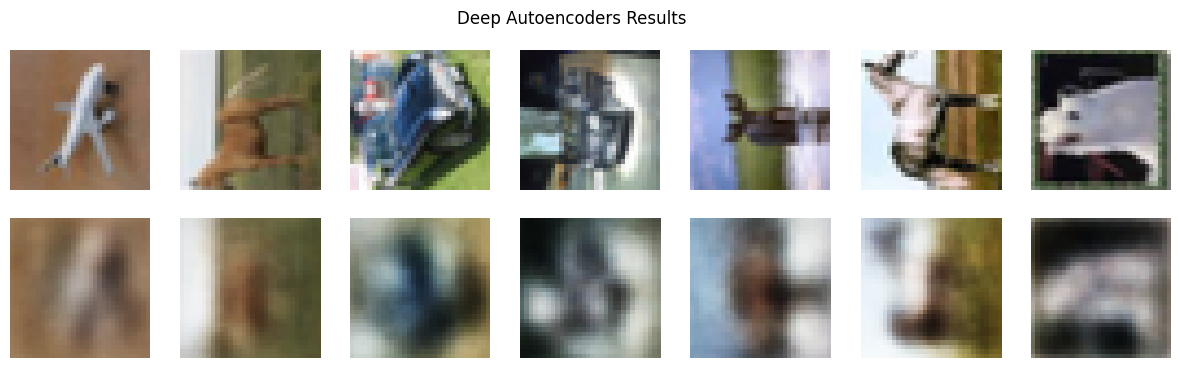

In [16]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
fig.suptitle('Deep Autoencoders Results')
for i in range(7):
    ax[0, i].imshow(data_a[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 3. Sparse Autoencoders

In [17]:
# Additional hyperparameters
beta = 0.0001
rho  = 0.05

In [18]:
sparse_model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
sparse_model.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [19]:
sparse_criterion = nn.MSELoss()
sparse_optimizer = torch.optim.Adam(sparse_model.parameters(),
                                    lr=learning_rate_,
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)

In [20]:
for epoch in range(num_epochs_):
    sparse_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        sparse_optimizer.zero_grad()
        outputs = sparse_model(images)
        flat_images = images.view(images.size(0), -1)
        rho_ = torch.mean(sparse_model.latent_).cpu().item()
        sparse_penalty = beta*kl_div(rho,rho_)
        loss = sparse_criterion(outputs,flat_images) + sparse_penalty
        with torch.no_grad():
          train_loss += loss.item()
        sparse_optimizer.zero_grad()
        loss.backward()
        sparse_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/20], Loss: 0.0295
Epoch [2/20], Loss: 0.0213
Epoch [3/20], Loss: 0.0187
Epoch [4/20], Loss: 0.0170
Epoch [5/20], Loss: 0.0160
Epoch [6/20], Loss: 0.0152
Epoch [7/20], Loss: 0.0145
Epoch [8/20], Loss: 0.0138
Epoch [9/20], Loss: 0.0134
Epoch [10/20], Loss: 0.0131
Epoch [11/20], Loss: 0.0129
Epoch [12/20], Loss: 0.0125
Epoch [13/20], Loss: 0.0122
Epoch [14/20], Loss: 0.0119
Epoch [15/20], Loss: 0.0117
Epoch [16/20], Loss: 0.0116
Stopping since train_loss has not improved in the last 12 epochs.
Epoch [17/20], Loss: 0.0115
Stopping since train_loss has not improved in the last 12 epochs.
Epoch [18/20], Loss: 0.0113
Epoch [19/20], Loss: 0.0112
Epoch [20/20], Loss: 0.0111


In [21]:
with torch.no_grad():
    for data_b, _ in train_loader:
        data_b = data_b.to(dev)
        sparse_recon = sparse_model(data_b)
        break
sparse_recon1 = sparse_recon.view(batch_size_, 3, 32, 32)

<Figure size 1600x1200 with 0 Axes>

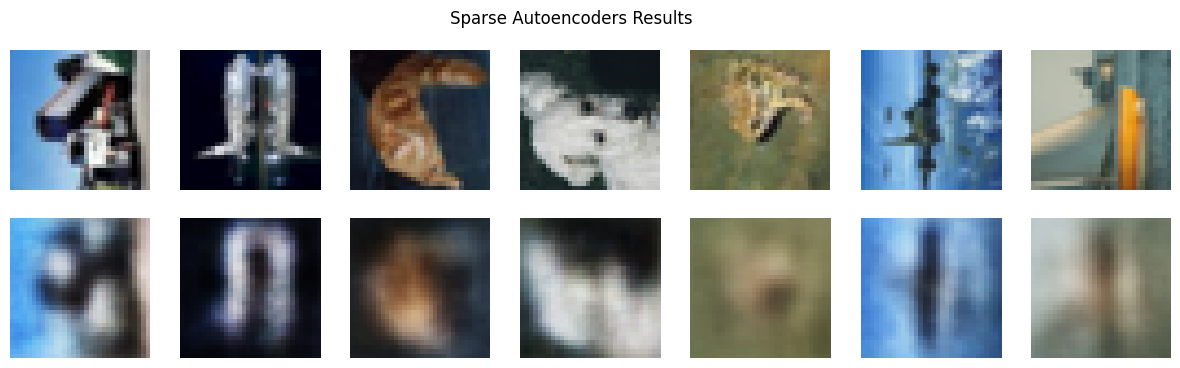

In [22]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
fig.suptitle('Sparse Autoencoders Results')
for i in range(7):
    ax[0, i].imshow(data_b[i].cpu().numpy().T)
    ax[1, i].imshow(sparse_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 4. Denoising Autoencoders

In [23]:
# Additional hyperparameters
noise = 0.1

In [24]:
denoising_model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
denoising_model.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [25]:
denoising_criterion = nn.MSELoss()
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(),
                                       lr=learning_rate_,
                                       betas=(0.9, 0.999),
                                       eps=1e-08,
                                       weight_decay=0,
                                       amsgrad=False)

In [26]:
for epoch in range(num_epochs_):
    denoising_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer.zero_grad()
        outputs = denoising_model(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss = denoising_criterion(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        denoising_optimizer.zero_grad()
        loss.backward()
        denoising_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/20], Loss: 0.0383
Epoch [2/20], Loss: 0.0307
Epoch [3/20], Loss: 0.0280
Epoch [4/20], Loss: 0.0260
Epoch [5/20], Loss: 0.0249
Epoch [6/20], Loss: 0.0242
Epoch [7/20], Loss: 0.0234
Epoch [8/20], Loss: 0.0227
Epoch [9/20], Loss: 0.0221
Epoch [10/20], Loss: 0.0218
Epoch [11/20], Loss: 0.0216
Epoch [12/20], Loss: 0.0214
Epoch [13/20], Loss: 0.0211
Epoch [14/20], Loss: 0.0208
Epoch [15/20], Loss: 0.0206
Epoch [16/20], Loss: 0.0204
Epoch [17/20], Loss: 0.0203
Epoch [18/20], Loss: 0.0202
Epoch [19/20], Loss: 0.0200
Epoch [20/20], Loss: 0.0199


In [27]:
with torch.no_grad():
    for data_c, _ in train_loader:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

<Figure size 1600x1200 with 0 Axes>

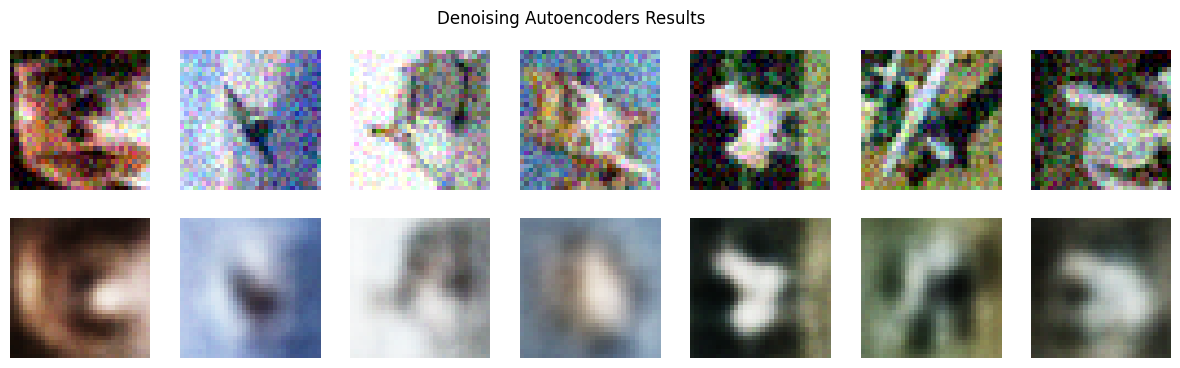

In [28]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results')
for i in range(7):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 5. Anomaly Detection

In [29]:
# Additional hyperparameters
anomaly_sample = 7

In [30]:
all_images = []
anomaly_loss = []
feature_images = []
target_images = []
with torch.no_grad():
    for anomaly_images, _ in train_loader:
        anomaly_images = anomaly_images.to(dev)
        anomaly_recon = model(anomaly_images)
        anomaly_flat_images = anomaly_images.view(anomaly_images.size(0), -1)
        batch_size = anomaly_recon.shape[0]
        for i_batch in range(batch_size):
          i_loss = criterion(anomaly_recon[i_batch],anomaly_flat_images[i_batch]).cpu()
          anomaly_loss.append(i_loss.numpy())
          feature_images.append(anomaly_images[i_batch])
          target_images.append(anomaly_recon[i_batch].view(3, 32, 32))
anomaly_loss = np.array(anomaly_loss)

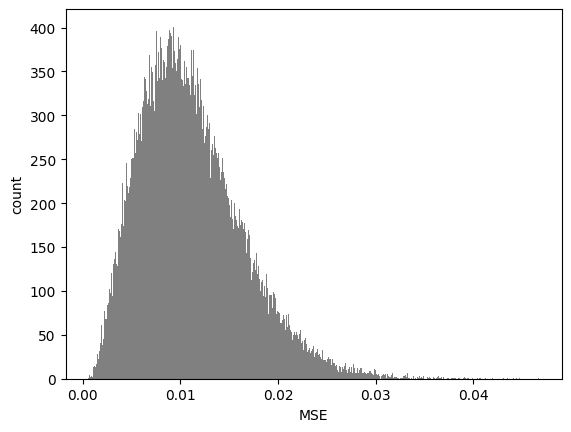

In [31]:
plt.hist(anomaly_loss, bins=500, color='grey')
plt.xlabel("MSE")
plt.ylabel("count")
plt.show()

In [32]:
anomalies_indx = np.argsort(anomaly_loss)[-anomaly_sample:]

<Figure size 1600x1200 with 0 Axes>

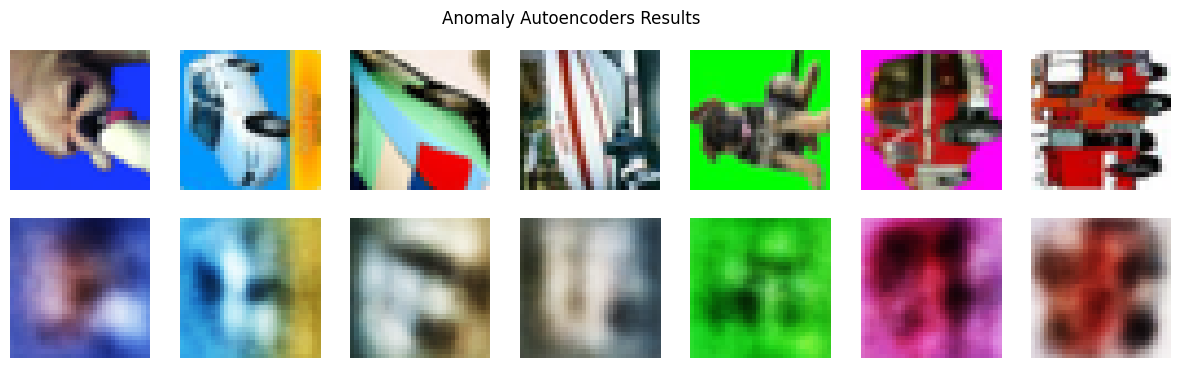

In [33]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, anomaly_sample, figsize=(15, 4))
fig.suptitle('Anomaly Autoencoders Results')
for i in range(anomaly_sample):
    ax[0, i].imshow(feature_images[anomalies_indx[i]].cpu().numpy().T)
    ax[1, i].imshow(target_images[anomalies_indx[i]].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()